In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from data_preparation import CreateDataset,\
                             load_images_and_labels, \
                             encode_labels, \
                             create_data_augmentation

from trainer import train_model, \
                    plot_losses, \
                    evaluate_model

import boto3
import multiprocessing

num_workers = multiprocessing.cpu_count()

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(num_workers)

In [2]:
device

device(type='cuda')

In [3]:
BATCH_SIZE = 32

In [4]:
data = "ck"
bucket_name = 'thesissagemakerbucket'
train_path = f'{data}/train'
test_path = f'{data}/test'

X_train, y_train = load_images_and_labels(bucket_name, train_path)
X_test, y_test = load_images_and_labels(bucket_name, test_path)

In [5]:
X = X_train + X_test
y = y_train + y_test

# split into training and testing data using sklearn
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=42)

In [6]:
# label_encoder, y_train, y_test = encode_labels(y_train, y_test)
label_encoder, y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)


In [7]:
transform = create_data_augmentation()

In [8]:
train_dataset = CreateDataset(X_train, y_train, transform=transform)
test_dataset = CreateDataset(X_test, y_test, transform=transform)
val_dataset = CreateDataset(X_val, y_val, transform=transform)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1 = None
        
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)
        
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 256).to(x.device)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [11]:
model = SimpleCNN(num_classes=7)
model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [12]:
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

best_model, train_losses, val_losses = train_model(
                                    model=model,
                                    train_loader=train_loader,
                                    val_loader=val_loader,
                                    criterion=criterion,
                                    optimizer=optimizer,
                                    device=device,
                                    epochs=500,
                                    patience=20
                                )

100%|██████████| 16/16 [00:03<00:00,  4.86it/s]


Epoch 1, Train Loss: 1.8715, Validation Loss: 1.8406


100%|██████████| 16/16 [00:02<00:00,  5.98it/s]


Epoch 2, Train Loss: 1.7781, Validation Loss: 1.7455


100%|██████████| 16/16 [00:02<00:00,  5.45it/s]


Epoch 3, Train Loss: 1.7464, Validation Loss: 1.6978


100%|██████████| 16/16 [00:02<00:00,  5.86it/s]


Epoch 4, Train Loss: 1.7208, Validation Loss: 1.6568


100%|██████████| 16/16 [00:02<00:00,  5.80it/s]


Epoch 5, Train Loss: 1.6697, Validation Loss: 1.5841


100%|██████████| 16/16 [00:02<00:00,  5.95it/s]


Epoch 6, Train Loss: 1.6363, Validation Loss: 1.5487


100%|██████████| 16/16 [00:02<00:00,  6.01it/s]


Epoch 7, Train Loss: 1.5787, Validation Loss: 1.4811


100%|██████████| 16/16 [00:02<00:00,  5.89it/s]


Epoch 8, Train Loss: 1.4768, Validation Loss: 1.3882


100%|██████████| 16/16 [00:02<00:00,  5.83it/s]


Epoch 9, Train Loss: 1.4347, Validation Loss: 1.3950


100%|██████████| 16/16 [00:02<00:00,  5.81it/s]


Epoch 10, Train Loss: 1.3791, Validation Loss: 1.3153


100%|██████████| 16/16 [00:02<00:00,  6.11it/s]


Epoch 11, Train Loss: 1.3665, Validation Loss: 1.2750


100%|██████████| 16/16 [00:02<00:00,  6.07it/s]


Epoch 12, Train Loss: 1.3051, Validation Loss: 1.2681


100%|██████████| 16/16 [00:02<00:00,  5.88it/s]


Epoch 13, Train Loss: 1.2955, Validation Loss: 1.2557


100%|██████████| 16/16 [00:02<00:00,  6.00it/s]


Epoch 14, Train Loss: 1.2865, Validation Loss: 1.2057


100%|██████████| 16/16 [00:02<00:00,  5.85it/s]


Epoch 15, Train Loss: 1.1764, Validation Loss: 1.1818


100%|██████████| 16/16 [00:02<00:00,  5.85it/s]


Epoch 16, Train Loss: 1.1703, Validation Loss: 1.1147


100%|██████████| 16/16 [00:02<00:00,  5.76it/s]


Epoch 17, Train Loss: 1.1241, Validation Loss: 1.0946


100%|██████████| 16/16 [00:02<00:00,  5.82it/s]


Epoch 18, Train Loss: 1.0955, Validation Loss: 1.1220


100%|██████████| 16/16 [00:02<00:00,  5.90it/s]


Epoch 19, Train Loss: 1.0765, Validation Loss: 1.0635


100%|██████████| 16/16 [00:02<00:00,  5.93it/s]


Epoch 20, Train Loss: 1.0671, Validation Loss: 0.9864


100%|██████████| 16/16 [00:02<00:00,  6.02it/s]


Epoch 21, Train Loss: 1.0550, Validation Loss: 1.0247


100%|██████████| 16/16 [00:02<00:00,  5.96it/s]


Epoch 22, Train Loss: 1.0190, Validation Loss: 0.9948


100%|██████████| 16/16 [00:02<00:00,  5.97it/s]


Epoch 23, Train Loss: 1.0042, Validation Loss: 1.0539


100%|██████████| 16/16 [00:02<00:00,  6.02it/s]


Epoch 24, Train Loss: 1.0134, Validation Loss: 1.0269


100%|██████████| 16/16 [00:02<00:00,  5.86it/s]


Epoch 25, Train Loss: 0.9785, Validation Loss: 0.9370


100%|██████████| 16/16 [00:02<00:00,  5.91it/s]


Epoch 26, Train Loss: 0.9625, Validation Loss: 0.9856


100%|██████████| 16/16 [00:02<00:00,  5.73it/s]


Epoch 27, Train Loss: 0.9794, Validation Loss: 0.9773


100%|██████████| 16/16 [00:02<00:00,  5.77it/s]


Epoch 28, Train Loss: 0.9022, Validation Loss: 0.9554


100%|██████████| 16/16 [00:02<00:00,  5.90it/s]


Epoch 29, Train Loss: 0.8826, Validation Loss: 0.9014


100%|██████████| 16/16 [00:02<00:00,  5.82it/s]


Epoch 30, Train Loss: 0.8826, Validation Loss: 0.8342


100%|██████████| 16/16 [00:02<00:00,  6.02it/s]


Epoch 31, Train Loss: 0.8401, Validation Loss: 0.8895


100%|██████████| 16/16 [00:02<00:00,  5.89it/s]


Epoch 32, Train Loss: 0.8753, Validation Loss: 0.7933


100%|██████████| 16/16 [00:02<00:00,  5.85it/s]


Epoch 33, Train Loss: 0.8774, Validation Loss: 0.8259


100%|██████████| 16/16 [00:02<00:00,  5.87it/s]


Epoch 34, Train Loss: 0.7670, Validation Loss: 0.8500


100%|██████████| 16/16 [00:02<00:00,  5.85it/s]


Epoch 35, Train Loss: 0.8028, Validation Loss: 0.8502


100%|██████████| 16/16 [00:02<00:00,  5.88it/s]


Epoch 36, Train Loss: 0.8031, Validation Loss: 0.7914


100%|██████████| 16/16 [00:02<00:00,  6.01it/s]


Epoch 37, Train Loss: 0.7709, Validation Loss: 0.9124


100%|██████████| 16/16 [00:02<00:00,  5.80it/s]


Epoch 38, Train Loss: 0.7447, Validation Loss: 0.7909


100%|██████████| 16/16 [00:02<00:00,  5.91it/s]


Epoch 39, Train Loss: 0.8197, Validation Loss: 0.7717


100%|██████████| 16/16 [00:02<00:00,  6.02it/s]


Epoch 40, Train Loss: 0.7372, Validation Loss: 0.8395


100%|██████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch 41, Train Loss: 0.7927, Validation Loss: 0.8159


100%|██████████| 16/16 [00:02<00:00,  5.84it/s]


Epoch 42, Train Loss: 0.7657, Validation Loss: 0.7518


100%|██████████| 16/16 [00:02<00:00,  5.67it/s]


Epoch 43, Train Loss: 0.7913, Validation Loss: 0.8040


100%|██████████| 16/16 [00:02<00:00,  5.99it/s]


Epoch 44, Train Loss: 0.7393, Validation Loss: 0.7273


100%|██████████| 16/16 [00:02<00:00,  5.76it/s]


Epoch 45, Train Loss: 0.7153, Validation Loss: 0.7193


100%|██████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch 46, Train Loss: 0.6918, Validation Loss: 0.6887


100%|██████████| 16/16 [00:02<00:00,  5.96it/s]


Epoch 47, Train Loss: 0.6454, Validation Loss: 0.7258


100%|██████████| 16/16 [00:02<00:00,  5.67it/s]


Epoch 48, Train Loss: 0.7072, Validation Loss: 0.6617


100%|██████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch 49, Train Loss: 0.7061, Validation Loss: 0.7023


100%|██████████| 16/16 [00:02<00:00,  5.60it/s]


Epoch 50, Train Loss: 0.7163, Validation Loss: 0.7150


100%|██████████| 16/16 [00:02<00:00,  5.67it/s]


Epoch 51, Train Loss: 0.6652, Validation Loss: 0.7141


100%|██████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch 52, Train Loss: 0.6890, Validation Loss: 0.6718


100%|██████████| 16/16 [00:02<00:00,  5.70it/s]


Epoch 53, Train Loss: 0.6486, Validation Loss: 0.6197


100%|██████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch 54, Train Loss: 0.6328, Validation Loss: 0.6444


100%|██████████| 16/16 [00:02<00:00,  5.68it/s]


Epoch 55, Train Loss: 0.6614, Validation Loss: 0.7303


100%|██████████| 16/16 [00:02<00:00,  5.75it/s]


Epoch 56, Train Loss: 0.6329, Validation Loss: 0.7329


100%|██████████| 16/16 [00:02<00:00,  5.75it/s]


Epoch 57, Train Loss: 0.6173, Validation Loss: 0.6549


100%|██████████| 16/16 [00:02<00:00,  5.96it/s]


Epoch 58, Train Loss: 0.5960, Validation Loss: 0.7013


100%|██████████| 16/16 [00:02<00:00,  5.89it/s]


Epoch 59, Train Loss: 0.6621, Validation Loss: 0.6442


100%|██████████| 16/16 [00:02<00:00,  5.77it/s]


Epoch 60, Train Loss: 0.6348, Validation Loss: 0.7284


100%|██████████| 16/16 [00:02<00:00,  5.99it/s]


Epoch 61, Train Loss: 0.6310, Validation Loss: 0.6838


100%|██████████| 16/16 [00:02<00:00,  5.95it/s]


Epoch 62, Train Loss: 0.5603, Validation Loss: 0.6108


100%|██████████| 16/16 [00:02<00:00,  5.81it/s]


Epoch 63, Train Loss: 0.6149, Validation Loss: 0.6115


100%|██████████| 16/16 [00:02<00:00,  5.93it/s]


Epoch 64, Train Loss: 0.5782, Validation Loss: 0.6206


100%|██████████| 16/16 [00:02<00:00,  5.76it/s]


Epoch 65, Train Loss: 0.6122, Validation Loss: 0.6239


100%|██████████| 16/16 [00:02<00:00,  5.87it/s]


Epoch 66, Train Loss: 0.5569, Validation Loss: 0.6260


100%|██████████| 16/16 [00:02<00:00,  6.03it/s]


Epoch 67, Train Loss: 0.5847, Validation Loss: 0.6599


100%|██████████| 16/16 [00:02<00:00,  5.93it/s]


Epoch 68, Train Loss: 0.6034, Validation Loss: 0.7037


100%|██████████| 16/16 [00:02<00:00,  5.86it/s]


Epoch 69, Train Loss: 0.5907, Validation Loss: 0.6854


100%|██████████| 16/16 [00:02<00:00,  5.79it/s]


Epoch 70, Train Loss: 0.5804, Validation Loss: 0.6471


100%|██████████| 16/16 [00:02<00:00,  5.80it/s]


Epoch 71, Train Loss: 0.6179, Validation Loss: 0.5823


100%|██████████| 16/16 [00:02<00:00,  5.99it/s]


Epoch 72, Train Loss: 0.5636, Validation Loss: 0.7481


100%|██████████| 16/16 [00:02<00:00,  5.92it/s]


Epoch 73, Train Loss: 0.5514, Validation Loss: 0.6930


100%|██████████| 16/16 [00:02<00:00,  6.00it/s]


Epoch 74, Train Loss: 0.5898, Validation Loss: 0.6099


100%|██████████| 16/16 [00:02<00:00,  6.11it/s]


Epoch 75, Train Loss: 0.5373, Validation Loss: 0.6765


100%|██████████| 16/16 [00:02<00:00,  5.92it/s]


Epoch 76, Train Loss: 0.5783, Validation Loss: 0.5869


100%|██████████| 16/16 [00:02<00:00,  5.91it/s]


Epoch 77, Train Loss: 0.5429, Validation Loss: 0.5508


100%|██████████| 16/16 [00:02<00:00,  5.82it/s]


Epoch 78, Train Loss: 0.5413, Validation Loss: 0.5889


100%|██████████| 16/16 [00:02<00:00,  5.66it/s]


Epoch 79, Train Loss: 0.5461, Validation Loss: 0.5992


100%|██████████| 16/16 [00:02<00:00,  5.87it/s]


Epoch 80, Train Loss: 0.5434, Validation Loss: 0.6183


100%|██████████| 16/16 [00:02<00:00,  5.90it/s]


Epoch 81, Train Loss: 0.5133, Validation Loss: 0.5438


100%|██████████| 16/16 [00:02<00:00,  5.91it/s]


Epoch 82, Train Loss: 0.4818, Validation Loss: 0.5484


100%|██████████| 16/16 [00:02<00:00,  5.93it/s]


Epoch 83, Train Loss: 0.4870, Validation Loss: 0.5613


100%|██████████| 16/16 [00:02<00:00,  5.92it/s]


Epoch 84, Train Loss: 0.5375, Validation Loss: 0.5798


100%|██████████| 16/16 [00:02<00:00,  5.93it/s]


Epoch 85, Train Loss: 0.4840, Validation Loss: 0.7468


100%|██████████| 16/16 [00:02<00:00,  6.01it/s]


Epoch 86, Train Loss: 0.5998, Validation Loss: 0.5304


100%|██████████| 16/16 [00:02<00:00,  5.94it/s]


Epoch 87, Train Loss: 0.5521, Validation Loss: 0.5334


100%|██████████| 16/16 [00:02<00:00,  5.70it/s]


Epoch 88, Train Loss: 0.4932, Validation Loss: 0.5252


100%|██████████| 16/16 [00:02<00:00,  5.87it/s]


Epoch 89, Train Loss: 0.5095, Validation Loss: 0.5321


100%|██████████| 16/16 [00:02<00:00,  5.76it/s]


Epoch 90, Train Loss: 0.5623, Validation Loss: 0.5475


100%|██████████| 16/16 [00:02<00:00,  6.00it/s]


Epoch 91, Train Loss: 0.4531, Validation Loss: 0.5121


100%|██████████| 16/16 [00:02<00:00,  6.05it/s]


Epoch 92, Train Loss: 0.4718, Validation Loss: 0.4941


100%|██████████| 16/16 [00:02<00:00,  5.69it/s]


Epoch 93, Train Loss: 0.4552, Validation Loss: 0.5845


100%|██████████| 16/16 [00:02<00:00,  5.96it/s]


Epoch 94, Train Loss: 0.4831, Validation Loss: 0.5306


100%|██████████| 16/16 [00:02<00:00,  5.74it/s]


Epoch 95, Train Loss: 0.4684, Validation Loss: 0.5393


100%|██████████| 16/16 [00:02<00:00,  5.86it/s]


Epoch 96, Train Loss: 0.4878, Validation Loss: 0.5219


100%|██████████| 16/16 [00:02<00:00,  5.97it/s]


Epoch 97, Train Loss: 0.4653, Validation Loss: 0.5594


100%|██████████| 16/16 [00:02<00:00,  5.86it/s]


Epoch 98, Train Loss: 0.4938, Validation Loss: 0.5298


100%|██████████| 16/16 [00:02<00:00,  5.91it/s]


Epoch 99, Train Loss: 0.4969, Validation Loss: 0.5446


100%|██████████| 16/16 [00:02<00:00,  5.96it/s]


Epoch 100, Train Loss: 0.4889, Validation Loss: 0.5934


100%|██████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch 101, Train Loss: 0.4392, Validation Loss: 0.4750


100%|██████████| 16/16 [00:02<00:00,  5.83it/s]


Epoch 102, Train Loss: 0.4730, Validation Loss: 0.5068


100%|██████████| 16/16 [00:02<00:00,  6.01it/s]


Epoch 103, Train Loss: 0.5016, Validation Loss: 0.4569


100%|██████████| 16/16 [00:02<00:00,  5.79it/s]


Epoch 104, Train Loss: 0.4632, Validation Loss: 0.5617


100%|██████████| 16/16 [00:02<00:00,  5.96it/s]


Epoch 105, Train Loss: 0.4934, Validation Loss: 0.4805


100%|██████████| 16/16 [00:02<00:00,  5.80it/s]


Epoch 106, Train Loss: 0.4499, Validation Loss: 0.5827


100%|██████████| 16/16 [00:02<00:00,  6.00it/s]


Epoch 107, Train Loss: 0.5370, Validation Loss: 0.5475


100%|██████████| 16/16 [00:02<00:00,  5.93it/s]


Epoch 108, Train Loss: 0.4173, Validation Loss: 0.5369


100%|██████████| 16/16 [00:02<00:00,  6.06it/s]


Epoch 109, Train Loss: 0.3773, Validation Loss: 0.5388


100%|██████████| 16/16 [00:02<00:00,  5.86it/s]


Epoch 110, Train Loss: 0.4367, Validation Loss: 0.4743


100%|██████████| 16/16 [00:02<00:00,  5.80it/s]


Epoch 111, Train Loss: 0.4053, Validation Loss: 0.4545


100%|██████████| 16/16 [00:02<00:00,  5.69it/s]


Epoch 112, Train Loss: 0.4403, Validation Loss: 0.5225


100%|██████████| 16/16 [00:02<00:00,  5.75it/s]


Epoch 113, Train Loss: 0.4506, Validation Loss: 0.4349


100%|██████████| 16/16 [00:02<00:00,  5.89it/s]


Epoch 114, Train Loss: 0.4097, Validation Loss: 0.5612


100%|██████████| 16/16 [00:02<00:00,  5.81it/s]


Epoch 115, Train Loss: 0.4216, Validation Loss: 0.4275


100%|██████████| 16/16 [00:02<00:00,  6.03it/s]


Epoch 116, Train Loss: 0.3669, Validation Loss: 0.4848


100%|██████████| 16/16 [00:02<00:00,  5.88it/s]


Epoch 117, Train Loss: 0.4211, Validation Loss: 0.4346


100%|██████████| 16/16 [00:02<00:00,  5.88it/s]


Epoch 118, Train Loss: 0.4328, Validation Loss: 0.4409


100%|██████████| 16/16 [00:02<00:00,  5.89it/s]


Epoch 119, Train Loss: 0.4277, Validation Loss: 0.4868


100%|██████████| 16/16 [00:02<00:00,  5.70it/s]


Epoch 120, Train Loss: 0.4231, Validation Loss: 0.4830


100%|██████████| 16/16 [00:02<00:00,  5.84it/s]


Epoch 121, Train Loss: 0.3658, Validation Loss: 0.5424


100%|██████████| 16/16 [00:02<00:00,  5.74it/s]


Epoch 122, Train Loss: 0.3977, Validation Loss: 0.5903


100%|██████████| 16/16 [00:02<00:00,  5.77it/s]


Epoch 123, Train Loss: 0.3925, Validation Loss: 0.5120


100%|██████████| 16/16 [00:02<00:00,  5.96it/s]


Epoch 124, Train Loss: 0.3631, Validation Loss: 0.5001


100%|██████████| 16/16 [00:02<00:00,  6.01it/s]


Epoch 125, Train Loss: 0.3928, Validation Loss: 0.5518


100%|██████████| 16/16 [00:02<00:00,  5.92it/s]


Epoch 126, Train Loss: 0.3796, Validation Loss: 0.4869


100%|██████████| 16/16 [00:02<00:00,  5.85it/s]


Epoch 127, Train Loss: 0.3750, Validation Loss: 0.5272


100%|██████████| 16/16 [00:02<00:00,  5.82it/s]


Epoch 128, Train Loss: 0.3676, Validation Loss: 0.4617


100%|██████████| 16/16 [00:02<00:00,  5.91it/s]


Epoch 129, Train Loss: 0.4204, Validation Loss: 0.5030


100%|██████████| 16/16 [00:02<00:00,  5.90it/s]


Epoch 130, Train Loss: 0.3986, Validation Loss: 0.5047


100%|██████████| 16/16 [00:02<00:00,  5.97it/s]


Epoch 131, Train Loss: 0.3597, Validation Loss: 0.4795


100%|██████████| 16/16 [00:02<00:00,  5.96it/s]


Epoch 132, Train Loss: 0.3831, Validation Loss: 0.4721


100%|██████████| 16/16 [00:02<00:00,  6.02it/s]


Epoch 133, Train Loss: 0.3917, Validation Loss: 0.4706


100%|██████████| 16/16 [00:02<00:00,  5.74it/s]


Epoch 134, Train Loss: 0.3470, Validation Loss: 0.4255


100%|██████████| 16/16 [00:02<00:00,  5.84it/s]


Epoch 135, Train Loss: 0.4180, Validation Loss: 0.4962


100%|██████████| 16/16 [00:02<00:00,  5.97it/s]


Epoch 136, Train Loss: 0.4077, Validation Loss: 0.4828


100%|██████████| 16/16 [00:02<00:00,  5.82it/s]


Epoch 137, Train Loss: 0.4422, Validation Loss: 0.4684


100%|██████████| 16/16 [00:02<00:00,  5.85it/s]


Epoch 138, Train Loss: 0.3212, Validation Loss: 0.5020


100%|██████████| 16/16 [00:02<00:00,  6.03it/s]


Epoch 139, Train Loss: 0.4192, Validation Loss: 0.4860


100%|██████████| 16/16 [00:02<00:00,  5.85it/s]


Epoch 140, Train Loss: 0.3262, Validation Loss: 0.5548


100%|██████████| 16/16 [00:02<00:00,  5.66it/s]


Epoch 141, Train Loss: 0.3653, Validation Loss: 0.4313


100%|██████████| 16/16 [00:02<00:00,  5.56it/s]


Epoch 142, Train Loss: 0.3189, Validation Loss: 0.3675


100%|██████████| 16/16 [00:02<00:00,  5.54it/s]


Epoch 143, Train Loss: 0.3651, Validation Loss: 0.4561


100%|██████████| 16/16 [00:02<00:00,  5.52it/s]


Epoch 144, Train Loss: 0.3469, Validation Loss: 0.4437


100%|██████████| 16/16 [00:02<00:00,  5.55it/s]


Epoch 145, Train Loss: 0.3301, Validation Loss: 0.4752


100%|██████████| 16/16 [00:02<00:00,  5.55it/s]


Epoch 146, Train Loss: 0.3730, Validation Loss: 0.6167


100%|██████████| 16/16 [00:02<00:00,  5.54it/s]


Epoch 147, Train Loss: 0.4563, Validation Loss: 0.4446


100%|██████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch 148, Train Loss: 0.3761, Validation Loss: 0.4696


100%|██████████| 16/16 [00:02<00:00,  5.50it/s]


Epoch 149, Train Loss: 0.4062, Validation Loss: 0.6420


100%|██████████| 16/16 [00:02<00:00,  5.56it/s]


Epoch 150, Train Loss: 0.3778, Validation Loss: 0.4327


100%|██████████| 16/16 [00:02<00:00,  5.53it/s]


Epoch 151, Train Loss: 0.3465, Validation Loss: 0.4738


100%|██████████| 16/16 [00:02<00:00,  5.87it/s]


Epoch 152, Train Loss: 0.3654, Validation Loss: 0.4401


100%|██████████| 16/16 [00:02<00:00,  5.99it/s]


Epoch 153, Train Loss: 0.3357, Validation Loss: 0.4832


100%|██████████| 16/16 [00:02<00:00,  5.94it/s]


Epoch 154, Train Loss: 0.3978, Validation Loss: 0.4318


100%|██████████| 16/16 [00:02<00:00,  5.90it/s]


Epoch 155, Train Loss: 0.3766, Validation Loss: 0.4214


100%|██████████| 16/16 [00:02<00:00,  5.94it/s]


Epoch 156, Train Loss: 0.3545, Validation Loss: 0.3952


100%|██████████| 16/16 [00:02<00:00,  5.95it/s]


Epoch 157, Train Loss: 0.3417, Validation Loss: 0.4424


100%|██████████| 16/16 [00:02<00:00,  5.79it/s]


Epoch 158, Train Loss: 0.3189, Validation Loss: 0.4523


100%|██████████| 16/16 [00:02<00:00,  5.94it/s]


Epoch 159, Train Loss: 0.3217, Validation Loss: 0.4335


100%|██████████| 16/16 [00:02<00:00,  5.94it/s]


Epoch 160, Train Loss: 0.3982, Validation Loss: 0.4675


100%|██████████| 16/16 [00:02<00:00,  5.78it/s]


Epoch 161, Train Loss: 0.3571, Validation Loss: 0.4857


100%|██████████| 16/16 [00:02<00:00,  5.85it/s]


Epoch 162, Train Loss: 0.3966, Validation Loss: 0.5258
Early stopping triggered


In [13]:
model_dir = f'{data}/models'

model_path = f'cnn_{data}_model.pt'
torch.save(best_model.state_dict(), model_path)

s3 = boto3.client('s3')
s3.upload_file(model_path, bucket_name, os.path.join(model_dir, model_path))

os.remove(model_path)

In [14]:
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
)

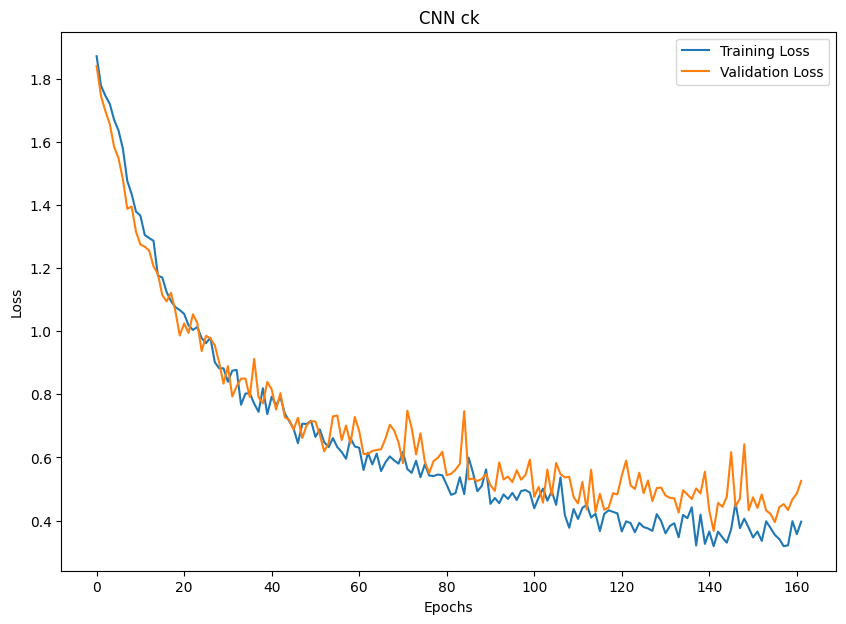

In [15]:
plot_losses(train_losses, val_losses, title=f"CNN {data}")

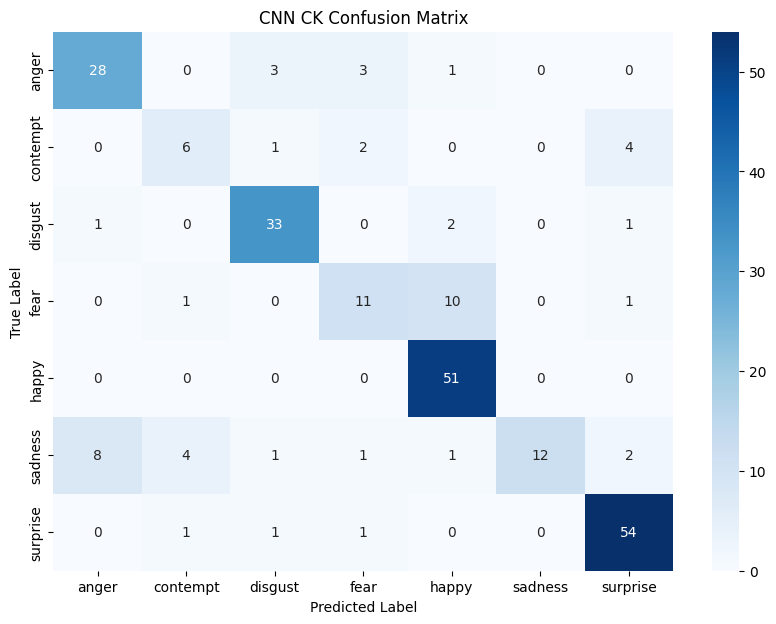

Test Accuracy: 0.7959
Precision: 0.7671
Recall: 0.7133
F1 Score: 0.7193
Classification Report:
               precision    recall  f1-score   support

       anger       0.76      0.80      0.78        35
    contempt       0.50      0.46      0.48        13
     disgust       0.85      0.89      0.87        37
        fear       0.61      0.48      0.54        23
       happy       0.78      1.00      0.88        51
     sadness       1.00      0.41      0.59        29
    surprise       0.87      0.95      0.91        57

    accuracy                           0.80       245
   macro avg       0.77      0.71      0.72       245
weighted avg       0.80      0.80      0.78       245



In [16]:
evaluate_model(model=model,
               test_loader=test_loader,
               device=device,
               data=f"CNN {data}",
               label_encoder=label_encoder)